Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms .Git repository link https://github.com/facebookresearch/detectron2?tab=readme-ov-file



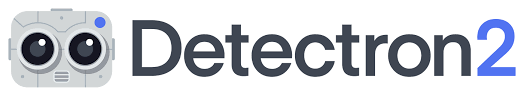

# Install Detectron2 Dependencies

In [1]:
!pip install pyyaml==5.1
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime
!pip install roboflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-n6kgbyl6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-n6kgbyl6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [2]:
# Some basic setup:
# Setup detectron2 logger
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import and Register Custom Detectron2 Data

### Load dataset

Go to this link to find the dataset [roboflow Data set link :]( https://universe.roboflow.com/children-and-adults-detection/children-and-adults-detection/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true)

In [3]:
!curl -L "https://app.roboflow.com/ds/u6nBqcI4rY?key=Grf7xT3IZz" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1250      0 --:--:-- --:--:-- --:--:--  1249
100 26.3M  100 26.3M    0     0  5274k      0  0:00:05  0:00:05 --:--:-- 8473k
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/Train322_jpg.rf.98605d6980e999c65ec4a03111f8c059.jpg  
 extracting: test/Train328_jpg.rf.2e252abad5a77d5d632bad803f79ac3f.jpg  
 extracting: test/Train333_jpg.rf.4da820f65782e0e94690294e56d8e69e.jpg  
 extracting: test/Train342_jpg.rf.4acde5c59487d25c0887be70e60945b3.jpg  
 extracting: test/Train344_jpg.rf.2527a79f0c46d9fe08035dc88cfb2bb9.jpg  
 extracting: test/Train346_jpg.rf.5085999c16933ce1952611cafa317c1f.jpg  
 extracting: test/Train352_jpg.rf.52c47fc0ada175a6465e00d39dbf9322.jpg  
 extracting: test/Train356_jpg.rf.8c142fe5d83c75c9b653a

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


## Show sample

WARNING [01/24 15:38:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/24 15:38:05 d2.data.datasets.coco]: Loaded 378 images in COCO format from /content/train/_annotations.coco.json
WARNING [01/24 15:38:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/24 15:38:05 d2.data.datasets.coco]: Loaded 31 images in COCO format from /content/test/_annotations.coco.json


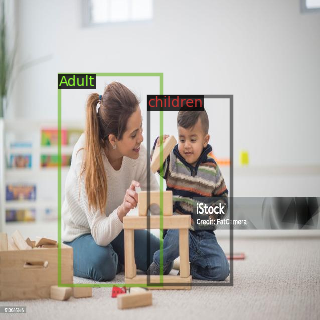

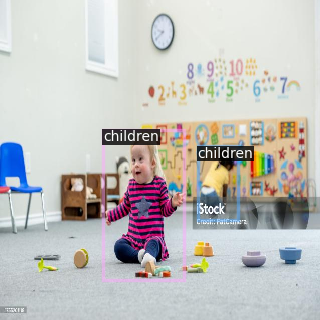

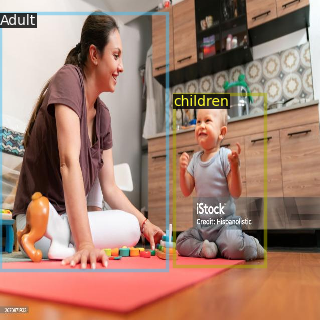

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_test")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

Get the model details in model zoo https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 350   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)


[01/24 15:38:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
model_final_280758.pkl: 167MB [00:01, 158MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [7]:
trainer.train()

[01/24 15:38:11 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/24 15:38:22 d2.utils.events]:  eta: 0:01:36  iter: 19  total_loss: 2.18  loss_cls: 1.282  loss_box_reg: 0.928  loss_rpn_cls: 0.02543  loss_rpn_loc: 0.01174    time: 0.2870  last_time: 0.3144  data_time: 0.0256  last_data_time: 0.0042   lr: 0.00013808  max_mem: 1737M
[01/24 15:38:31 d2.utils.events]:  eta: 0:01:30  iter: 39  total_loss: 1.571  loss_cls: 0.5825  loss_box_reg: 0.9329  loss_rpn_cls: 0.01991  loss_rpn_loc: 0.01415    time: 0.2953  last_time: 0.2627  data_time: 0.0090  last_data_time: 0.0045   lr: 0.00028079  max_mem: 1737M
[01/24 15:38:37 d2.utils.events]:  eta: 0:01:22  iter: 59  total_loss: 1.291  loss_cls: 0.4138  loss_box_reg: 0.861  loss_rpn_cls: 0.01312  loss_rpn_loc: 0.01039    time: 0.2934  last_time: 0.3137  data_time: 0.0111  last_data_time: 0.0050   lr: 0.00042351  max_mem: 1737M
[01/24 15:38:43 d2.utils.events]:  eta: 0:01:17  iter: 79  total_loss: 1.063  loss_cls: 0.3196  loss_box_reg: 0.7632  loss_rpn_cls: 0.003583  loss_rpn_loc: 0.00807    time: 0.2915  l

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [8]:
#save the model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [9]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

[01/24 15:50:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

# Evaluation

In [10]:
test_metadata = MetadataCatalog.get("my_dataset_test")

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [01/24 15:50:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/24 15:50:48 d2.data.datasets.coco]: Loaded 31 images in COCO format from /content/test/_annotations.coco.json
[01/24 15:50:48 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| children-or.. | 0            |   Adult    | 22           |  children  | 53           |
|               |              |            |              |            |              |
|     total     | 75           |            |              |            |              |
[01/24 15:50:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/24 15:50:48 d2.data.common]: Serializi

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[01/24 15:50:50 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0011 s/iter. Inference: 0.0792 s/iter. Eval: 0.0002 s/iter. Total: 0.0805 s/iter. ETA=0:00:01
[01/24 15:50:52 d2.evaluation.evaluator]: Total inference time: 0:00:02.321083 (0.089272 s / iter per device, on 1 devices)
[01/24 15:50:52 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.080250 s / iter per device, on 1 devices)
[01/24 15:50:52 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/24 15:50:52 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/24 15:50:52 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/24 15:50:52 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/24 15:50:52 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[01/24 15:50:52 d2.evaluation.

In [12]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

# Inference with Detectron2 Saved Weights



### Test dataset

In [13]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


Output hidden; open in https://colab.research.google.com to view.

### inference for any image

[01/24 15:52:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

tensor([2, 1, 1, 2], device='cuda:0')
Boxes(tensor([[120.9244,  71.9257, 169.2184, 166.1988],
        [ 13.7120,  10.9365, 100.5446, 159.5355],
        [185.2322,  30.3552, 233.1199, 160.4277],
        [179.0081,  31.6687, 233.6400, 165.8486]], device='cuda:0'))
tensor([0.9393, 0.8404, 0.7333, 0.6348], device='cuda:0')


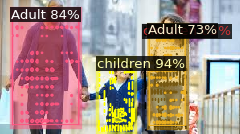

tensor([1, 2], device='cuda:0')
Boxes(tensor([[398.1749,  13.0068, 778.7966, 435.1675],
        [ 82.1576,  82.3782, 371.0923, 466.1774]], device='cuda:0'))
tensor([0.9050, 0.7446], device='cuda:0')


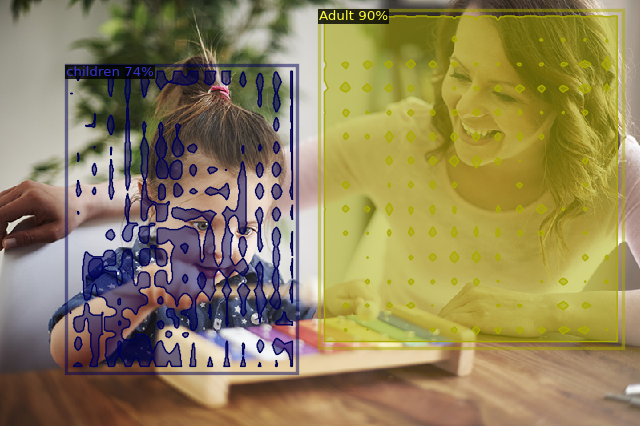

tensor([2, 1, 1], device='cuda:0')
Boxes(tensor([[388.3026,  73.5220, 506.8537, 313.9396],
        [257.9779,  27.6921, 412.8997, 386.8154],
        [356.5882,  78.4703, 600.9137, 381.7088]], device='cuda:0'))
tensor([0.7876, 0.7436, 0.6128], device='cuda:0')


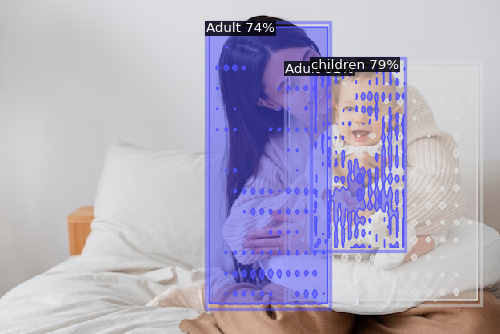

tensor([1, 2], device='cuda:0')
Boxes(tensor([[321.0184,  23.7564, 547.1186, 333.0854],
        [121.6532, 102.7584, 285.2200, 343.1746]], device='cuda:0'))
tensor([0.8667, 0.7215], device='cuda:0')


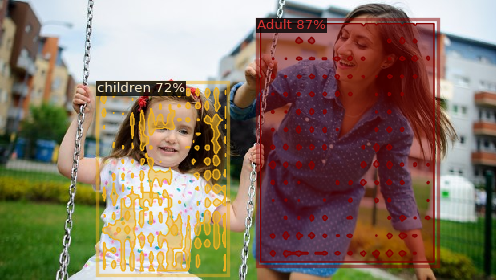

In [14]:
import  requests
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from google.colab.patches import cv2_imshow

# Initialize the configuration
cfg = get_cfg()

# Load the base configuration file for your model
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the score threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
# Set the number of classes (excluding the background class)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Replace 3 with the number of classes you trained on (excluding background)
# Specify the path to your fine-tuned model weights
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"  # Path to your fine-tuned weights

# Initialize the predictor
predictor = DefaultPredictor(cfg)



urls = [
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ09q9-SnHjARL2_h4WNFz9m_pFT346kN395w&s",
    "https://www.ctbehavioralhealth.com/wp-content/uploads/2017/10/child-adult-evaluation.jpg",
    "https://img.freepik.com/free-photo/front-view-mother-holding-newborn-baby_23-2150227213.jpg",
    "https://wp.en.aleteia.org/wp-content/uploads/sites/2/2018/06/web3-child-swing-mother-fun-smile-laugh-shutterstock.jpg?resize=620,350&q=75"
]


for i, url in enumerate(urls):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Convert the response content to a NumPy array
        image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        # Decode the NumPy array to an OpenCV image
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Perform predictions
        outputs = predictor(image)
        print(outputs["instances"].pred_classes)
        print(outputs["instances"].pred_boxes)
        print(outputs["instances"].scores)


        v = Visualizer(image[:, :, ::-1],
                      metadata=test_metadata,
                      scale=0.8
                      )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1])



